# Test of Reservoir Computer prediction of Lorenz '63 System

First, import necessary modules

In [1]:
import numpy as np
import pandas as pd
import scipy.sparse as sparse
from scipy.stats import pearsonr
from scipy.sparse import linalg
from scipy.linalg import solve, pinv
import matplotlib.pyplot as plt

## Define necessary  functions

In [2]:
def dxdt_lorenz(x,time,r_t, sigma = 10., beta = 8/3, rho = 28.):
    # Evaluates derivative of Lorenz '63 system with a time-dependent
    # rho value. For constant rho, input the r_t_const function.
    return np.array([sigma*(- x[0] + x[1]),\
                     r_t(time)*rho*x[0] - x[1] - x[0]*x[2],\
                     x[0]*x[1]-beta*x[2]])
    
def rk4(x, time, tau, r_t, dxdt):
    # Fourth order Runge-Kutta integrator
    
    k1 = dxdt(x, time, r_t)
    k2 = dxdt(x + k1/2*tau, time + tau/2, r_t)
    k3 = dxdt(x + k2/2*tau, time + tau/2, r_t)
    k4 = dxdt(x + tau*k3, time + tau, r_t)
    
    xnext = x + 1/6*tau*(k1+2*k2+2*k3+k4)
    return xnext

def getLorenzData(data_length, r_t, dxdt_lorenz,transient_length = 1000, tau = 0.01,sample_tau = 0.05, seed = 5):
    # Obtains time series of Lorenz '63 states after some initial transient time
    sampling_rate = round(sample_tau/tau)
    np.random.seed(seed)
    x = np.random.rand(3)
    time = -transient_length*tau
    for i in range(0,transient_length):
        x = rk4(x,time,tau,r_t,dxdt_lorenz)
        time += tau
    
    data = np.zeros((3,data_length))
    data[:,0] = x
    for i in range(0,data_length-1):
        data[:,i+1] = rk4(data[:,i],time,tau,r_t,dxdt_lorenz)
        time += tau
    
    data = data[:,::sampling_rate]
    return data

def r_t_cosine(time, period = 500, max_height = 48/28):
    # Function for oscillating rho value (not used here)
    r = 1 + (max_height-1.)/2 - (max_height-1)/2*np.cos(2*np.pi/period*time)
    return r

def r_t_const(time, value = 1):
    # Function for constant rho value
    r = value
    return r

def advanceReservoir(win,A_mat,x,u,leakage):
    # Equation for advancing reservoir state. Here, we do not use a bias factor.
    x_next = leakage*x + (1-leakage)*np.tanh(A_mat.dot(x) + np.matmul(win,u))
    return x_next

def getPrediction(win, A_mat, wout, x, predict_length, leakage):
    # Obtains a prediction of length predict_length given the trained reservoir parameters
    prediction = np.zeros((wout.shape[0],predict_length))
    aug_x = np.copy(x)
    aug_x[::2] = np.power(x[::2],2)
    prediction[:,0] = np.matmul(wout,aug_x)
    
    for pred_idx in range(0,predict_length - 1):
        x = advanceReservoir(win, A_mat, x, prediction[:,pred_idx], leakage)
        aug_x = np.copy(x)
        aug_x[::2] = np.power(x[::2],2)
        prediction[:,pred_idx + 1] = np.matmul(wout,aug_x)
        
    return prediction

## Next, define reservoir hyperparameters and the length of and number of predictions to be made. Finally,  we obtain a training and testing data sequence from the Lorenz '63 system.

In [3]:
input_weight = 1e-2 #Input weight for reservoir
spectral_radius = 0.9 #Spectral radius, maximum magnitude eigenvalue of reservoir adjacency matrix 
regularization = 1e-5 #Tikhonov regularization term
average_degree = 3 #Average in-degree for each reservoir node
leakage = 0 #Leakage parameter, unused
# forget = 1
# inv_forget = 1/forget
data_seed = 30  #Seed for initializing data

int_step = 0.005
steps = np.arange(0.005,0.06,0.005) #Time step size for Lorenz system
num_steps = len(steps)
transient_length = 1000 #Length of initial transient input to reservoir before training begins
data_length_base = int(1e5)
data_length = data_length_base*steps/int_step #Length of full data set
train_length = 5000 #Length of training data
predict_length = 20  #Length of each prediction
predict_gap_length = 1 #Length of time between subsequent predictions
num_predictions = 3000  #Total number of predictions made

approx_num_nodes = 300 #Approximate Number of nodes in the reservoir (rounded such that each input connects to the same number of nodes)
np.random.seed(data_seed)

## Randomly generate reservoit adjacency and input matrices and initialize the reservoir node states.

In [4]:
input_size = 3
num_nodes = int(np.ceil(approx_num_nodes/input_size)*input_size); #Calculate number of nodes

# Create the adjacency matrix and set the spectral radius
A_mat = sparse.random(num_nodes,num_nodes, density = average_degree/num_nodes)
eg = linalg.eigs(A_mat, k = 1, return_eigenvectors=False)
A_mat = spectral_radius/np.abs(eg[0])*A_mat
print(A_mat.data[:10])

# Set the adjacency matrix such that all inputs go to the same number of nodes
q = int(np.floor(num_nodes/(input_size)))
win = np.zeros((num_nodes,input_size))
for i in range(input_size):
    np.random.seed(i)
    ip = (-1 + 2*np.random.randn(q));
    win[i*q:(i+1)*q,i] = input_weight*ip;

[0.28104585 0.26146857 0.1655575  0.08468628 0.52045049 0.22841742
 0.14135072 0.46482451 0.37468858 0.47175555]


## After an initial transient, record reservoir states and use them to calculate the output matrix.

In [5]:
wouts = np.zeros((input_size,num_nodes,num_steps))
#Initialize reservoir state vector x and states array
x = np.zeros((num_nodes,num_steps))
states = np.zeros((num_nodes, train_length,num_steps))
train_input_sequence = np.zeros((input_size,data_length_base,num_steps))
for i in range(num_steps):
    train_input_sequence[:,:,i] = getLorenzData(round(data_length[i]),r_t_const,dxdt_lorenz,tau = int_step,sample_tau = steps[i])
    
    # Advance reservoir state
    for t in range(transient_length):
        x[:,i] = advanceReservoir(win,A_mat,x[:,i],train_input_sequence[:,t,i],leakage)

    #Begin recording states for training
    states[:,0,i] = x[:,i];

    for t in range(train_length-1):
        states[:,t+1,i] = advanceReservoir(win,A_mat,states[:,t,i],train_input_sequence[:,t+transient_length,i],leakage)

    x[:,i] = states[:,-1,i]

    # We augment the reservoir states by squaring some of them to break the odd
    # symmetry of the tanh function. We find experimentally that this improves
    # performance for some systems.
    aug_states = states[:,:,i]
    aug_states[::2,:] = np.power(states[::2,:,i],2)
    idenmat = regularization*sparse.identity(num_nodes)
    data_trstates = np.matmul(train_input_sequence[:,transient_length:transient_length+train_length,i],np.transpose(aug_states))
    print(data_trstates[0:2,0])
    states_trstates = np.matmul(aug_states,np.transpose(aug_states))
    states_trstates_inv = pinv(states_trstates + idenmat)
    wouts[:,:,i] = np.matmul(data_trstates,states_trstates_inv)
    norm_error = np.sqrt(np.mean(train_input_sequence[:,:,i]**2))
    print(norm_error)
    training_error = (wouts[:,:,i] @ aug_states) - train_input_sequence[:,transient_length:transient_length+train_length,i]
    training_nrms_error = np.sqrt(np.mean(training_error**2))/norm_error
    print(training_nrms_error)

[-3129.22580583 -2521.32886021]
16.068669764043904
1.3086171301913346e-05
[-1907.64046264 -1309.19347872]
16.058247937505985
1.241106040621635e-05
[-2152.78860193 -1680.55538394]
16.061186022310252
1.4238269000970638e-05
[-2140.44872363 -1697.6073515 ]
16.06175891288696
1.7772920037811665e-05
[-2099.65338931 -1688.15534117]
16.056034105588164
2.1697003896523135e-05
[-2366.43952081 -1956.99494011]
16.055444508437017
2.4902942327274266e-05
[-2407.62519806 -1998.83689358]
16.05429986866846
3.073269840399532e-05
[-2366.4214733 -1956.0737886]
16.054603918892944
3.833056340351532e-05
[-2386.87159792 -1958.58302479]
16.054079411856357
4.814271755229957e-05
[-2569.63079315 -2132.27914883]
16.05156123932146
5.877312403673807e-05
[-2452.51359422 -2003.53678984]
16.052271929714536
7.475906619053293e-05


## We evaluate the reservoir's performance over a set of prediction periods beginning right after training ends (this is not necessary, but is easiest). We then display the valid prediction times.

In [6]:
# Initialize data matrices
error_cutoff = 1;
predictions = np.zeros((input_size,predict_length,num_predictions,num_steps))
errors = np.zeros((predict_length,num_predictions,num_steps))
difference = np.zeros((input_size,predict_length,num_predictions,num_steps))
valid_times = np.zeros((num_predictions,num_steps))
    
for k in range(num_steps):
    norm_error = np.sqrt(np.mean(train_input_sequence[:,:,k]**2))
    for pred in range(num_predictions):
        # Obtain the prediction
        predictions[:,:,pred,k] = getPrediction(win,A_mat,wouts[:,:,k],x[:,k],predict_length,leakage)
        start_pred_idx = transient_length + train_length + pred*predict_gap_length - 1

        # Compare prediction to true system and calculate valid prediction time given the normalized RMS error cutoff
        truth = train_input_sequence[:,start_pred_idx:start_pred_idx + predict_length,k]
        difference[:,:,pred,k] = predictions[:,:,pred,k] - truth
        errors[:,pred,k] = np.linalg.norm(predictions[:,:,pred,k] - truth, axis = 0)/norm_error
        for i in range(predict_length):
            if errors[i,pred,k] > error_cutoff:
                break
            else:
                valid_times[pred] += 1

        # Advance the reservoir node state to the next prediction
        for i in range(predict_gap_length):
            x[:,k] = advanceReservoir(win,A_mat,x[:,k],train_input_sequence[:,start_pred_idx + i,k],leakage)

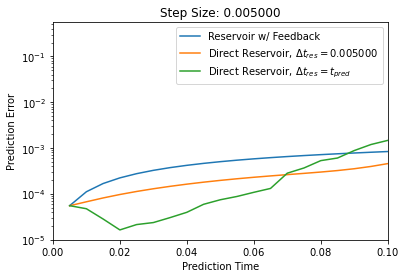

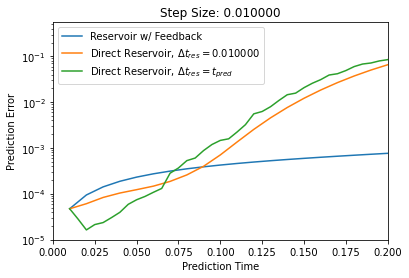

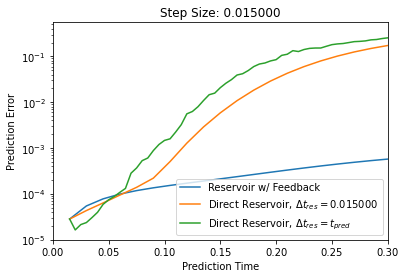

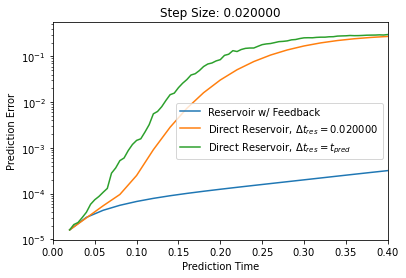

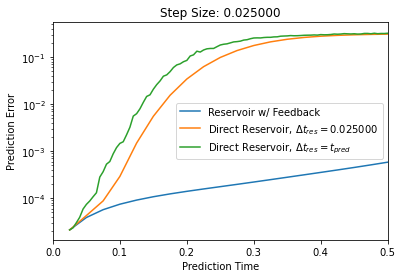

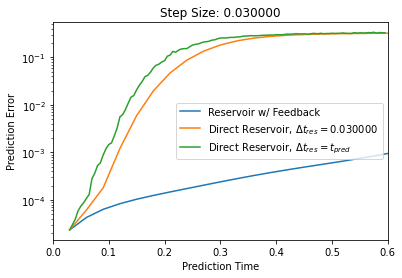

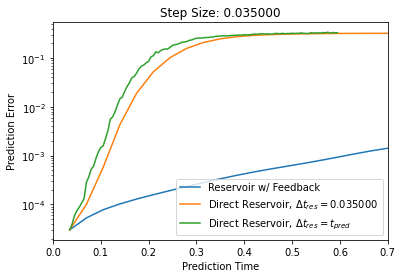

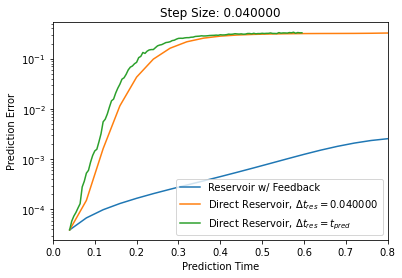

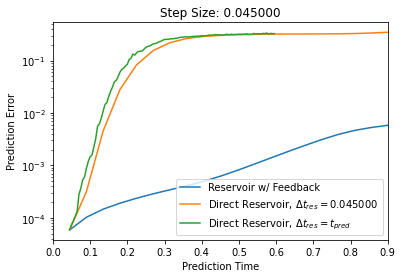

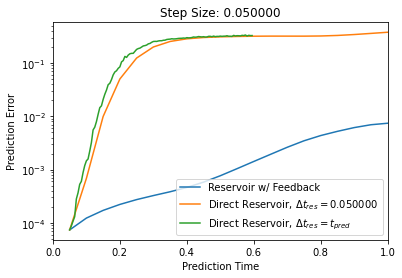

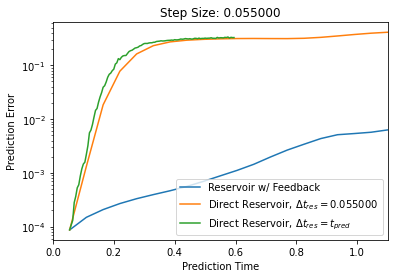

In [8]:
avg_pred_error = np.transpose(np.sqrt(np.mean(difference**2,axis = (0,2)))/norm_error)
avg_multistep_pred_error = np.loadtxt('Lorenz63Data/lorenz_mutltistep_trainerror.csv', delimiter = ',')
avg_direct_pred_error = np.loadtxt('Lorenz63Data/lorenz_mutltistep_direct_trainerror.csv', delimiter = ',')
times_direct = steps[0]*np.arange(1,len(avg_direct_pred_error)+1)
for i in range(num_steps):
    times = steps[i]*np.arange(1,21)
    times_fb = steps[i]*np.arange(1,predict_length+1)
    plt.plot(times_fb,avg_pred_error[i,:],label = r'Reservoir w/ Feedback')
    plt.plot(times,avg_multistep_pred_error[i,:],label = r'Direct Reservoir, $\Delta t_{res} = %f$' % steps[i])
    plt.plot(times_direct[i:],avg_direct_pred_error[i:],label = r'Direct Reservoir, $\Delta t_{res} = t_{pred}$')
    plt.xlabel('Prediction Time')
    plt.ylabel('Prediction Error')
    plt.title('Step Size: %f' % steps[i])
    plt.legend()
    plt.xlim(0,times_fb[-1])
    plt.yscale('log')
    plt.savefig('compare_prediction_error_step%f.pdf' % (steps[i]))
    plt.show()
    

## Plot an example prediction

In [ ]:
times = np.arange(0,step*predict_length,step)
plt.plot(times, truth[0,:],label = 'Truth')
plt.plot(times, predictions[0,:,-1],label = 'Prediction')
plt.xlabel('Time')
plt.ylabel('x(t)')
plt.show()

plt.plot(times, truth[1,:],label = 'Truth')
plt.plot(times, predictions[1,:,-1],label = 'Prediction')
plt.xlabel('Time')
plt.ylabel('y(t)')
plt.show()

plt.plot(times, truth[2,:],label = 'Truth')
plt.plot(times, predictions[2,:,-1],label = 'Prediction')
plt.xlabel('Time')
plt.ylabel('z(t)')
plt.show()